# Ride Share Allocation
## Implementation of Gopalakrishnan et al.(2016) Algorithm

This algorithm intake a list of passengers and their destination, and designs a specific graph who's max flow min cost reduction is isomorphic to the best route to take.

The biggest problem is that this algorithm assumes uncapacitated vehicles, and takes the pickup order as inputted. For the first problem we can assume now that this is a bus-sharing problem (think Google sending shuttles to pick up their employees), and for the second we can do some sorting on the input. To turn the algorithm into returning paths for capacitated vehicles, we would need to modify the max_flow_min_cost algorithm for a graph, which is fairly complicated/involved.

Code can be found [on Arya's Github](www.github.com/misingnoglic/cost-allocation)

Authors:
Arya Boudaie;
Kiranmayi P;
Nidhi Rathi.


### Backend Logic Code:

This part of the code deals with backend functions. Feel free to just read the comments under the function headers, or just skip to Main Algorithm

In [64]:
__author__ = "Arya"
import networkx as nx # Graph Library
import matplotlib.pyplot as plt # Plotting library
from matplotlib.colors import cnames
from itertools import cycle
import random
%matplotlib inline

In [65]:
def new_round(num, digits):
    '''
    Because nx.nextwork_simplex doesnt work for 
    floats, this function just multiplies num
    by digits and turns in into an integer
    '''
    return int(num*(10**digits))

def node_numbers(node):
    '''
    Numbers the nodes, to allow for sorting 
    when printing them
    '''
    
    if node[0]=='source': return 0
    if node[0]=='sink': return 1
    if node[0]=='destination': return float('inf')
    else:
        if node[0][0]=="d": print node
        cost= 2+2*int(node[0][0])
        if node[0][1:]=='out': cost+=1
        return cost

def sort_nodes(nodes):
    '''Sorts a list of nodes'''
    return sorted(nodes,key=node_numbers)

def sort_edges(edges):
    '''sorts a list of edges'''
    return sorted(edges, key = lambda x:node_numbers([x[0]]))

### Basic functions integral to the construction

These are the building functions that are used in the algorithm. We can replace them, as the main algorithm doesn't make any assumptions on these.  It might be interesting to use other distance functions for instance.

In [66]:
from math import sqrt
def distance(node1,node2):
    '''Simple euclidian distance formula between two points'''
    x1 = node1[0]
    x2 = node2[0]
    y1 = node1[1]
    y2 = node2[1]
    return sqrt((x2-x1)**2 + (y2-y1)**2)

def max_distance(points):
    '''Gets the max distance between two points in the graph'''
    current = 0
    for node1 in points:
        for node2 in points:
            d = distance(node1,node2) # distance from n1 & n2
            if d>current: 
                current=d # store larger distance
    return current

# Used in main algorithm to see which m' has lowest cost
def cost_of_min_cost(G):
    '''
    Given a graph, it gives the cost of the paths 
    in the max flow min cost over the graph.
    It also returns the paths from source to 
    destination as a list, for convenience
    '''
    
    # Gets the max flow min cost path from source to sink
    flow_path = nx.max_flow_min_cost(G,'source','sink',weight='cost')
    
    # The beginning has the directions for where each cab starts
    beginning = flow_path['source'] 
    
    total_cost = 0
    # each node which the flow_path indicates to go
    start_paths = [n[0] for n in beginning.items() if n[1]==1] 
    paths = []
    
    # For each node that a cab goes to in order to start
    for start_node in start_paths: 
        path = [start_node]
        curr_node=start_node
        path_cost = 0
        # Loop through the path until you reach the destination
        while curr_node!='destination': 
            # Node that current node travels to
            next_node = [n for n in 
                         flow_path[curr_node].items() 
                         if n[1]==1][0][0] 
            # Add the cost of the edge from the current node 
            #to the next node
            path_cost += G.edge[curr_node][next_node]['cost'] 
            # Switch current node to be the node travelled to
            curr_node = next_node 
            if G.node[curr_node]['type']=='passenger in': 
                path.append(curr_node)
        # When that node is finished, add it to the total cost 
        # and start over
        total_cost += path_cost 
        # add destination to end of path
        paths.append(path+['destination']) 
    return total_cost, paths  

# Main Algorithm

In the code I include comments on what part of the 
paper is being represented by the code

1. The algorithm takes a list of passengers (x,y position tuples), and a destination (x,y) tuple. Passengers are listed in  pickup order

2. From that, it creates a source node, a sink node, a destination node, and two nodes for every passenger (an in and an out node)

3. For each passenger it adds an edge from its in node to its out node (cost 0, capacity 1)

4. Add an edge from the source to every in node (cost 0, capacity 1)

5. Calculate a value L, which is larger than the maximum distance between two points multiplied by the number of passengers.

6. Create an edge from each out node to the destination with the cost being the distance between the passenger and the destination

7. Add an edge from each out/in pair (where the index of the out is less than the index of the in) where the cost is the distance between the two passengers minus L.

In [67]:
def generate_graph(passengers, destination, 
                   annotate=False, complete=False, mistake=False):
    '''
    This code generates the graph described by Raga in 
    section 7.3 steps 1 through 5.
    The code is annotated with what it is doing in comments
    passengers = List of x,y coordinates for each passenger
    destination = x,y tuple with coord. of destination
    annotate=True if you want print statements
    complete=True if you want to do unordered paths
    
    '''
    
    G=nx.DiGraph() # Create a directed graph
    
    # The rest of the algorithm closely follows Raga's paper
    # I quote the steps directly
    
    # Step 1
    # "s and t denote the source and sink vertices, respectively"
    G.add_node("source", type="meta")
    G.add_node("sink", type="meta")
    
    # Step 2
    # For each passenger/pickup location u ∈ N , we create 
    # two vertices and an edge: an entry vertex u_in, an exit 
    # vertex u_out, and an edge of cost 0 and capacity 1 directed
    # from u_in to u_out. We also create a vertex n+1 
    # corresponding to the dropoff location.
    i = 1
    for passenger in passengers:
        # {}in.format(x) will give the node the name xin, 
        # for any integer x
        G.add_node("{}in".format(i), number=i, x=passenger[0], 
                   y=passenger[1], type="passenger in")
        G.add_node("{}out".format(i),number=i, x=passenger[0], 
                   y=passenger[1], type="passenger out")
        G.add_edge("{}in".format(i), "{}out".format(i), cost=0, 
                   capacity=1)
        i+=1
    G.add_node("destination", x=destination[0], y=destination[1], 
               type="destination")
    
    # Step 3
    # We create n edges, one each of cost 0 and capacity 1 from 
    # the source vertex s to each of the entry vertices u_in, 
    # u ∈ N.
    for node in G.nodes(data=True):
        if node[1]['type']=="passenger in":
            G.add_edge("source", node[0], cost=0, capacity=1)
    
    # Calculating L
    # passengers + [destination] is the concatonation of the 
    # two lists
    L = len(passengers)*max_distance(passengers + 
                                     [destination]) + 1 
    if annotate: print "L = {}".format(L)   
        
    # Step 4
    # We create n edges, one each of cost SuD and capacity 1 
    # from each of the exit vertices uout, u ∈ N, to the 
    # dropoff vertex n + 1
    for node in G.nodes(data=True):
        if node[1]['type']=="passenger out":
            # Calculating SuD
            cost = distance(destination, (node[1]['x'],
                                          node[1]['y']))-L 
            
            if mistake: cost+=L
            cost = new_round(cost, 2)
            node_name = node[0]
            # Creating the edge with that cost
            G.add_edge(node_name,"destination", cost=cost, 
                       capacity=1) 
    # Step 5
    # To encode the pickup order, for each 1 ≤ u < v ≤ n we 
    # create an edge of cost (SuSv − L) and capacity 1 directed 
    # from u_out to v_in, where L is a sufficiently large number 
    # satisfying L > 2*max [u,v∈N∪{n+1} SuSv].    
    
    for u in range(1,len(passengers)+1): # For each u
        # If we want a complete graph we will do every v, 
        # otherwise just v>u
        if complete: 
            start = 1
        else: 
            start = u+1
        for v in range(start, len(passengers)+1):
            if u!=v:
                G.add_edge("{}out".format(u), "{}in".format(v), 
                           cost=new_round(distance(
                            passengers[u-1], passengers[v-1])-L, 
                                          2), capacity=1) 
    # pass this graph to step 6
    return allocation(G, annotate=annotate) 


### Step 6:
Finally, it creates a separate graph for each of n passengers, with each one having
an edge from destination to sink with cost 0 and capacity m' (for each value m'
from 1 to n).

After the graphs are generated, it iterates over each graph and calculate the cost for n passengers pick up and  returns the path with minimum cost

In [68]:
def allocation(G, annotate=False):
    '''
    Given the G in the generate_graph algo, it gives the graph w/
    a node from destination to source m' with the minimum cost
    for traversing the max flow min cost graph.
    annotate=True if you want print statements
    '''        
    # Step 6
    # We add a final edge of cost 0 and capacity m′ 
    # from the dropoff vertex n + 1 to the
    # sink vertex t, thereby limiting the maximum flow 
    # in the network to m′ units.
    
    # In this implementation, we make n copies of this graph, 
    # and give each one an m' from i to n
    passengers = [node for node in G.nodes(data=True) 
                  if node[1]['type']=='passenger in']
    possible_graphs = [G.copy() for i in range(len(passengers))]
    
    for i, pg in enumerate(possible_graphs, 1):
        # All the different m' values
        pg.add_edge("destination", "sink", cost=0, capacity=i) 
        
    
    # Now over these graphs we have to find the one 
    # with the lowest cost in the min cost max flow algorithm
    # In other words which m' gives the lowest cost
    min_cost = float('inf')
    min_flow_graph = None
    costs = []
    paths = []
    optimal = 0
    
    for index, pg in enumerate(possible_graphs):
        if annotate: print "{} cabs: ".format(index+1),
        # For each possible graph, calculate the cost. 
        c, path = cost_of_min_cost(pg)
        c = new_round(c,2)
        paths.append(path)
        costs.append(c)
        if annotate:
            print "path: ",path,"--",
            print "cost: ",c/10000.0
        
        # If the cost is less than previous graphs, store it
        if c<min_cost:
            min_cost=c
            min_flow_graph=pg
            optimal = index
    if annotate: print "Optimal path with {} cabs".format(
            optimal+1), paths[optimal]
    return min_flow_graph,paths[optimal]

### Frontend Functions

The following functions allow the user to interract with the algorithm and visually inspect the output. (They are not commented, as they aren't important to the algorithm.)

In [69]:
def allocation_interractive(**kwargs):
    '''
    Interractive version of the function
    '''
    players = int(raw_input("How many players are there: "))
    player_coordinates = []
    for i in range(1,players+1):
        coord = raw_input('''What are the x and y 
                          coordinates for player {}: '''.format(i))
        coord = [int(x) for x in coord.split()]
        player_coordinates.append((coord[0],coord[1]))
    destination = raw_input('''What are the x and y coordinates 
                                for the destination: ''')
    destination = [int(x) for x in destination.split()]
    return generate_graph(player_coordinates, 
                    (destination[0], destination[1]), **kwargs)

def draw_paths(G, paths=None, title="Graph of optimal routes"):
    '''
    Given a graph and paths through the graph, it plots 
    them w/ arrows. If path not given, it gets the path with 
    min cost max flow.
    '''
    if paths == None:
        paths = cost_of_min_cost(G)[1]
    
    # Way of getting random colors
    color_names = list("gbrcmyk")
    new_colors=[]
    if len(paths) > len(color_names):
        new_colors = [c for c in cnames.keys() 
                      if not("light" in c)]
        random.shuffle(new_colors)
    #iterator through colors (so it will repeat)
    colors = cycle(color_names+new_colors) 
    
    # plot labels
    plt.xlabel("X")
    plt.ylabel("Y") 
    plt.title(title+" - {} cabs".format(len(paths)))
    
    # add all the x,y points of the passengers
    xs = []
    ys = []
    for n in G.nodes(data=True):
        if n[1]['type'] == 'passenger in':
            xs.append(n[1]['x'])
            ys.append(n[1]['y'])
    plt.plot(xs,ys,'ro')
    
    # plot the destination
    destination = G.node['destination']
    plt.plot(destination['x'], destination['y'], 'bo')
    xs.append(destination['x'])
    ys.append(destination['y'])
    
    # determine the axis
    plt.axis([min(xs)-1,max(xs)+1,min(ys)-1,max(ys)+1])
    
    for path in paths: # for each path
        c = colors.next() # choose a random color
        for i in range(len(path)-1): # for each pair in the path
            from_node = G.node[path[i]] 
            to_node = G.node[path[i+1]]
            try:
                # draw an arrow from from_node to to_node
                plt.arrow(from_node['x'], from_node['y'], 
                          (to_node['x']-from_node['x']),  
                      (to_node['y']-from_node['y']), 
                          head_width=0.2, head_length=0.05, 
                      length_includes_head=True,fc=c, ec=c)
            except: 
                # if error is thrown, it means that the point 
                # was repeated
                continue
    
    plt.show()

Running the cell below allows you to interractively give the program a set of passengers and a destination. For example, try the simple case - two passengers at (0,0) and (1,0) - destination (2,0)

How many players are there: 2
What are the x and y coordinates for player 1: 0 0
What are the x and y coordinates for player 2: 1 0
What are the x and y coordinates for the destination: 2 0
L = 5.0
1 cabs:  path:  [['1in', '2in', 'destination']] -- cost:  -8.0
2 cabs:  path:  [['2in', 'destination'], ['1in', 'destination']] -- cost:  -7.0
Optimal path with 1 cabs [['1in', '2in', 'destination']]


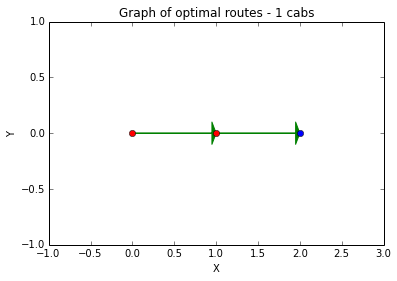

In [70]:
# Run this cell to run the interractive simulation
a, paths = allocation_interractive(annotate=True)
draw_paths(a,paths)

#### List of all the nodes

In [71]:
sort_nodes(a.nodes(data=True))

[('source', {'type': 'meta'}),
 ('sink', {'type': 'meta'}),
 ('1in', {'number': 1, 'type': 'passenger in', 'x': 0, 'y': 0}),
 ('1out', {'number': 1, 'type': 'passenger out', 'x': 0, 'y': 0}),
 ('2in', {'number': 2, 'type': 'passenger in', 'x': 1, 'y': 0}),
 ('2out', {'number': 2, 'type': 'passenger out', 'x': 1, 'y': 0}),
 ('destination', {'type': 'destination', 'x': 2, 'y': 0})]

#### List of all the edges

In [72]:
# All the edges in the graph
sort_edges(a.edges(data=True))

[('source', '2in', {'capacity': 1, 'cost': 0}),
 ('source', '1in', {'capacity': 1, 'cost': 0}),
 ('1in', '1out', {'capacity': 1, 'cost': 0}),
 ('1out', '2in', {'capacity': 1, 'cost': -400}),
 ('1out', 'destination', {'capacity': 1, 'cost': -300}),
 ('2in', '2out', {'capacity': 1, 'cost': 0}),
 ('2out', 'destination', {'capacity': 1, 'cost': -400}),
 ('destination', 'sink', {'capacity': 1, 'cost': 0})]

#### Drawing of the constructed graph
This gets quite complicated with large number of players, but shows the graph constructed by the algorithm, with the source, sink, destination, and in/out nodes, as well as all the edges. Layout is random.

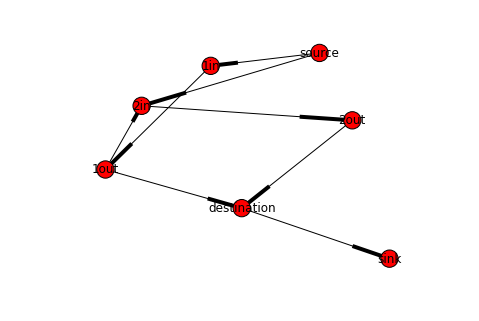

In [73]:
nx.draw(a, with_labels=True)

In [74]:
# The path that should be taken 
# Starting from the source, a 1 in the node in the dictionary 
# means send 1 cab there
nx.max_flow_min_cost(a,'source','sink',weight='cost')

{'1in': {'1out': 1},
 '1out': {'2in': 1, 'destination': 0},
 '2in': {'2out': 1},
 '2out': {'destination': 1},
 'destination': {'sink': 1},
 'sink': {},
 'source': {'1in': 1, '2in': 0}}

## More examples


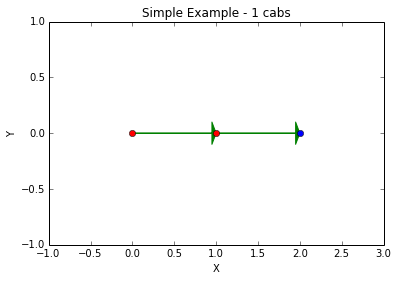

In [75]:
passengers = [(0,0), (1,0)]
destination = (2,0)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="Simple Example")

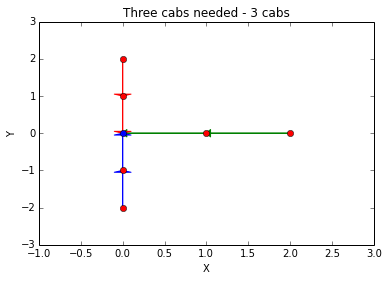

In [76]:
passengers = [(2,0), (1,0), (0,2), (0,1), (0,-2), (0,-1)]
destination = (0,0)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="Three cabs needed")

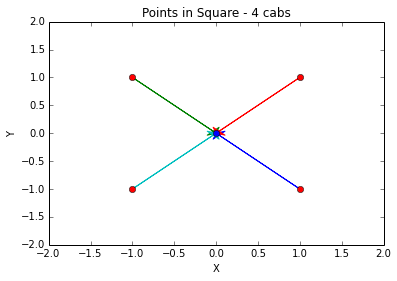

In [77]:
passengers = [(1,1), (-1,1), (-1,-1), (1,-1)]
destination = (0,0)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="Points in Square")

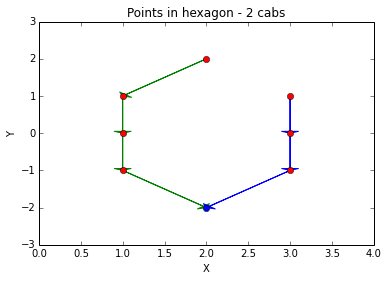

In [78]:
passengers = [(2,2), (1,1), (1,0), (1,-1), (3,1), (3,0), (3,-1)]
destination = (2,-2)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="Points in hexagon")

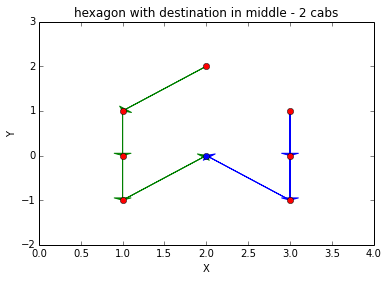

In [79]:
passengers = [(2,2), (1,1), (1,0), (1,-1), (3,1), (3,0), (3,-1)]
destination = (2,0)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="hexagon with destination in middle")

The below graphs are completely random (except for destination being 0,0) - feel free to change the variables in the below cell to get different graphs. The first random graph will have non optimal paths, as the ordering is set, but the second graph shows the paths when we order the pickups by distance from destination (largest first). 

In [80]:
# Constraints for random graphs
n = 50 # number of passengers
min_x = -30
max_x = 30
min_y = -30
max_y = 30

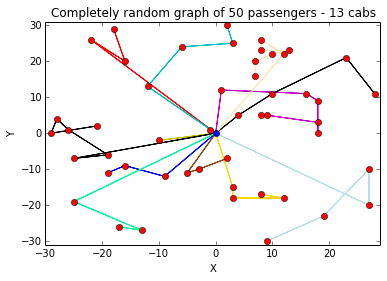

In [81]:
passengers = [(random.randint(min_x,max_x), 
               random.randint(min_y,max_y)) for i in range(n)]
destination = (0,0)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title='''Completely random graph 
           of {} passengers'''.format(n))

Here we order the passengers and the paths taken are much more optimal.

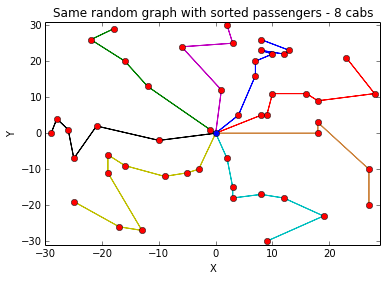

In [82]:
passengers = sorted(passengers, key = 
                    lambda x : distance(x, destination), 
                    reverse=True)
a, paths = generate_graph(passengers, destination)
draw_paths(a,paths, title="Same graph with sorted passengers")

## The bug we found in the paper
As described in the presentation, the original cost of the edge from a passenger's out node to the destination was just the distance between the passenger and the destination. This subtle bug caused the optimal number of cabs to always be 1, and we fixed it by subtracting the same L from the cost.

This is not a formal proof, but since the problem was only found in the implementation, we have recreated the results of the mistake below with the mistake=True flag - on graphs which we have already seen the best path for.

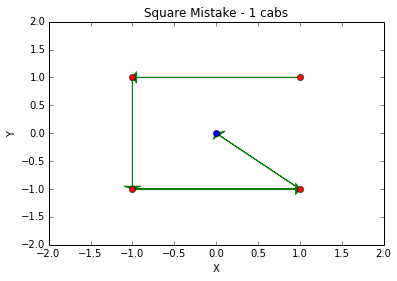

In [83]:
passengers = [(1,1), (-1,1), (-1,-1), (1,-1)]
destination = (0,0)
a, paths = generate_graph(passengers, destination, mistake=True)
draw_paths(a,paths, title="Square Mistake")

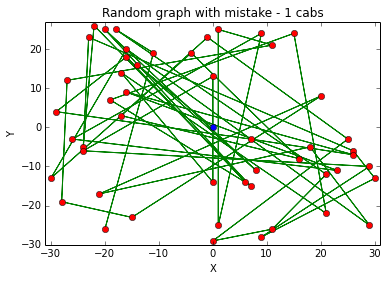

In [84]:
passengers = [(random.randint(min_x,max_x), 
               random.randint(min_y,max_y)) for i in range(n)]
destination = (0,0)
a, paths = generate_graph(passengers, destination, mistake=True)
draw_paths(a,paths, title="Random graph with mistake".format(n))

## Unused work
We tried to make progress in calculating costs, but as the min cost max flow algorithm is not based on individual rationality, the output of optimal path need not satisy SIR. 
However, the following part of code can be used to verify if the resultant path is SIR compliant or not.

In [85]:
def operational_cost(G, route, meter_fare = 8):
    oc = 0
    oc_values = []
    players_on_route = 1
    for i in range(len(route)-1):
        first = G.node[route[i]]
        second = G.node[route[i+1]]
        oc += meter_fare*(distance( (first['x'], first['y']), 
        (second['x'], second['y']) ) / float(players_on_route) )
        oc_values.append((distance( (first['x'], first['y']), 
        (second['x'], second['y']) ) / float(players_on_route) ))
        players_on_route +=1
    return oc
    
def shared_cost_per_player(G, route, meter_fare=8):
    operational_costs = []
    inconvenience_costs = [0]
    for i in range(len(route)-1):
        operational_costs.append(operational_cost(G, route[i:], 
                                                  meter_fare)) 
    
    #IC(i) is the inconvenience cost caused due to 
    # player(i) to other players
    for i in range(1,len(route)-1):
        first = G.node[route[i-1]]
        second = G.node[route[i]]
        destination = G.node["destination"]
        new_distance = (distance( (first['x'], first['y']), 
                                 (second['x'], second['y']) )+
                             distance( (second['x'], second['y']), 
                                      (destination['x'], 
                                       destination['y']) ))
        original_distance = distance( (first['x'], first['y']), 
                                     (destination['x'], 
                                      destination['y']) )
        
        inconvenience_costs.append(
            (new_distance-original_distance)*meter_fare)
    
    total_cost = []
    for i in range(len(route)-1):
        total_cost.append(
            operational_costs[i]+i*inconvenience_costs[i])
    
    return total_cost
    
def original_cost_per_player(G, meter_fare=8):
    costs = []
    players = [n for n in G.nodes(data=True) 
               if n[1]['type']=='passenger in']
    destination = G.node["destination"]
    for player in players:
        costs.append(
            meter_fare*(distance((player[1]['x'], player[1]['y']), 
                        (destination['x'], destination['y']) )))
    return costs